In [51]:
import pandas as pd
import numpy as np
import ydf
import matplotlib.pyplot as plot
import scipy
import gov_expenditure



In [52]:
df = pd.read_csv("dam_data_imputed_flumevale.csv")
df["Assessment"].value_counts()

Assessment
Satisfactory      1850
Fair               650
Not Rated          619
Not Available      232
Unsatisfactory     120
Poor                51
Name: count, dtype: int64

In [53]:

train_df = df.copy()
#train_df.columns
train_df = train_df.drop(columns=["ID", "Years Modified", "Assessment Date", "Assessment Date","Loss given failure - prop (Qm)","Loss given failure - liab (Qm)", "Loss given failure - BI (Qm)", "Total Loss Given Failure", "Expected Loss Value"])

test_df = df.copy()

model = ydf.GradientBoostedTreesLearner(label="Probability of Failure", task=ydf.Task.REGRESSION).train(train_df)

Train model on 3522 examples
Model trained in 0:00:00.541101


In [54]:
model = ydf.GradientBoostedTreesLearner(label="Probability of Failure", task=ydf.Task.REGRESSION)
evaluation = model.cross_validation(test_df, folds = 10)

In [55]:
def change_due_to_assessment(test_df: pd, assessment:str):
    print(test_df)
    for i in range(len(test_df)):
        if test_df.loc[i, "Assessment"] == "Not Rated" or test_df.loc[i, "Assessment"] == "Not Available":
            test_df.loc[i, "Assessment"] = assessment

change_due_to_assessment(test_df, "Poor")
model = ydf.GradientBoostedTreesLearner(label="Probability of Failure", task=ydf.Task.REGRESSION).train(train_df)
new_probabilities = model.predict(test_df) 
print(test_df.to_string())

             ID     Region Regulated Dam       Primary Purpose Primary Type  \
0     SOAD02636  Flumevale            No          Water Supply     Concrete   
1     SOAD02906  Flumevale           Yes               Missing        Earth   
2     SOAD03835  Flumevale            No            Recreation     Concrete   
3     SOAD05705  Flumevale            No            Recreation        Earth   
4     SOAD07112  Flumevale            No            Irrigation        Earth   
...         ...        ...           ...                   ...          ...   
3517  SOAD17916  Flumevale            No         Hydroelectric     Rockfill   
3518  SOAD16637  Flumevale           Yes  Flood Risk Reduction        Earth   
3519  SOAD13182  Flumevale           Yes  Flood Risk Reduction        Earth   
3520  SOAD20031  Flumevale           Yes  Flood Risk Reduction        Earth   
3521  SOAD13852  Flumevale            No         Hydroelectric     Concrete   

      Height (m)  Length (km)  Volume (m3)  Year Co

In [60]:
model.describe()
train_df["Probability of Failure"].max()

np.float64(0.19)

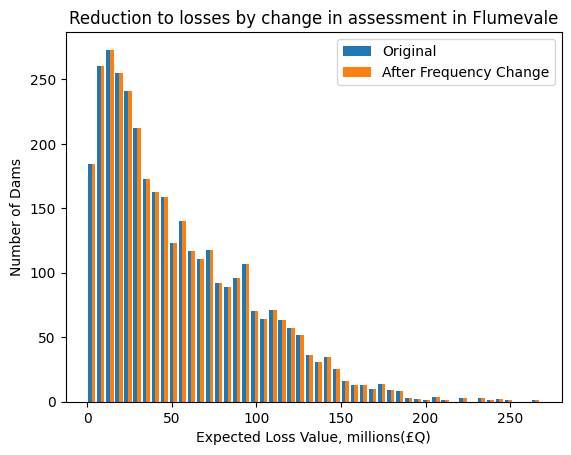

In [57]:
new_df = df.copy(True) 
new_df = new_df.replace(new_df["Probability of Failure"], pd.Series(new_probabilities))
for i in range(new_df.index.size):
    new_df.loc[i, "Expected Loss Value"] = test_df.loc[i, "Probability of Failure"] * new_df.loc[i, "Total Loss Given Failure"] 
new_df.to_csv(f"machine_learning_assessment_adjusted_{df.loc[0, "Region"]}.csv", index = False)
make_graph = True
if make_graph:
    compare_new = new_df["Expected Loss Value"].to_numpy()
    compare_old = df["Expected Loss Value"].to_numpy()
    plot.hist([compare_old, compare_new], bins=50,label=["Original", "After Frequency Change"])
    plot.xlabel("Expected Loss Value, millions(£Q)")
    plot.ylabel("Number of Dams")
    plot.title(f"Reduction to losses by change in assessment in {df.loc[0, "Region"]}")
    plot.legend()
    plot.savefig(f"assessment_adjusted_expected_loss__{df.loc[0, "Region"]}_histogram.png")

In [58]:
new_data = gov_expenditure.total_loss_percentile(f"machine_learning_assessment_adjusted_{df.loc[0, "Region"]}.csv", 0, 100, False)
old_data = gov_expenditure.total_loss_percentile("dam_data_imputed_flumevale.csv", 0, 100, False)
gov_threshold = scipy.stats.norm.ppf(95/100) * old_data[2] + old_data[1] #one standard deviation, covers 95% to 99.7% of all cases
gov_reserve = scipy.stats.norm.ppf(0.997) * old_data[2] + old_data[1] - gov_threshold
new__gov_detachment_point = scipy.stats.norm.ppf(0.997) * new_data[2] + new_data[1] #the amount of money for 99.7% of all cases
new_gov_threshold = new__gov_detachment_point - gov_reserve
new_percentile = scipy.stats.norm.cdf(new_gov_threshold, new_data[1], new_data[2])
if True:
    print("Based on the original data, the threshold should be:", gov_threshold, "and the reserve is", gov_reserve)
    print(f"The expected value of the new data is {new_data[1]} with standard deviation {new_data[2]}.")
    print(f"This means the government detachment point is {new__gov_detachment_point} and the detachment point is {new_gov_threshold}.")
    print(f"The insurance companies will expect to pay {new_data[1]} instead of {old_data[1]}. This represents a decreased payout of {new_data[1] - old_data[1]}")
    print(f"The government threshold will also shift by {new_gov_threshold - gov_threshold}")
    print(f"This is the {new_percentile * 100} percentile.")

ans = {f"Threshold percent {df.loc[0,"Region"]}" : new_percentile}
ans.update({f"Original Threshold {df.loc[0,"Region"]}": gov_threshold})
ans.update({f"New Threshold {df.loc[0,"Region"]}" : new_gov_threshold})
ans.update({f"Change in Threshold {df.loc[0,"Region"]}" : new_gov_threshold - gov_threshold})
ans.update({f"Original Expected Payout {df.loc[0,"Region"]}" : old_data[1]})
ans.update({f"New Expected Payout {df.loc[0,"Region"]}" : new_data[1]})
ans.update({f"Change in Payout {df.loc[0,"Region"]}" : new_data[1] - old_data[1]})
print(str(ans))

Based on the original data, the threshold should be: 212000.38010772964 and the reserve is 13447.601843987737
The expected value of the new data is 191945.27088000003 with standard deviation 12192.640669734978.
This means the government detachment point is 225447.98195171737 and the detachment point is 212000.38010772964.
The insurance companies will expect to pay 191945.27088000003 instead of 191945.27088000003. This represents a decreased payout of 0.0
The government threshold will also shift by 0.0
This is the 95.0 percentile.
{'Threshold percent Flumevale': np.float64(0.9500000000000001), 'Original Threshold Flumevale': np.float64(212000.38010772964), 'New Threshold Flumevale': np.float64(212000.38010772964), 'Change in Threshold Flumevale': np.float64(0.0), 'Original Expected Payout Flumevale': np.float64(191945.27088000003), 'New Expected Payout Flumevale': np.float64(191945.27088000003), 'Change in Payout Flumevale': np.float64(0.0)}
